## Test different modeling approaches

In [1]:

# Setup and imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

# Sklearn imports - all in one place to avoid scattered imports
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import sys

_NOTEBOOK_DIR = Path().resolve()
_candidate_paths = [
    _NOTEBOOK_DIR,
    _NOTEBOOK_DIR / 'code',
    _NOTEBOOK_DIR.parent,
    _NOTEBOOK_DIR.parent / 'code',
]

for _candidate in _candidate_paths:
    if (_candidate / 'model_utils.py').exists():
        sys.path.insert(0, str(_candidate))
        break

from model_utils import (
    DEFAULT_EXCLUDE_COLS,
    prepare_features,
    evaluate_model,
    get_top10_predictions,
    create_sample_weights,
    log_results_to_mlflow,
    calculate_top_k_overlap,
    compute_ranking_metrics,
)

# MLflow experiment setup
try:
    import mlflow
    MLFLOW_AVAILABLE = True
except ImportError:
    mlflow = None
    MLFLOW_AVAILABLE = False
    print("⚠️  MLflow not installed; skipping run tracking.")
else:
    MLFLOW_TRACKING_DIR = (_NOTEBOOK_DIR.parent / 'mlruns').resolve()
    mlflow.set_tracking_uri(f"file://{MLFLOW_TRACKING_DIR}")
    mlflow.set_experiment("box_office_modeling")

DEFAULT_MLFLOW_TAGS = {
    "project": "box_office",
    "notebook": "4_try_different_modeling_approaches",
}

def build_validation_snapshot(df: pd.DataFrame, target_col: str) -> pd.DataFrame:
    columns = []
    for col in ("title", "release_year"):
        if col in df.columns:
            columns.append(col)
    if target_col in df.columns and target_col not in columns:
        columns.append(target_col)
    if not columns:
        return df.copy()
    return df[columns].copy()

# Gradient Boosting imports
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
    print("✅ XGBoost available")
except ImportError:
    XGBOOST_AVAILABLE = False
    print("⚠️  XGBoost not available. Install with: pip install xgboost")

try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
    print("✅ LightGBM available")
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("⚠️  LightGBM not available. Install with: pip install lightgbm")

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("🔬 Box Office Prediction: Experimental Modeling Approaches")
print("=" * 60)
print("📊 All libraries imported and ready for experimentation")
print("🎯 Goal: Test different modeling approaches for 2026 predictions")
print(f"💡 Available models: Ridge, Decision Tree, Random Forest{', XGBoost' if XGBOOST_AVAILABLE else ''}{', LightGBM' if LIGHTGBM_AVAILABLE else ''}")


✅ XGBoost available
✅ LightGBM available
🔬 Box Office Prediction: Experimental Modeling Approaches
📊 All libraries imported and ready for experimentation
🎯 Goal: Test different modeling approaches for 2026 predictions
💡 Available models: Ridge, Decision Tree, Random Forest, XGBoost, LightGBM


In [2]:
# Load the processed dataset
df = pd.read_csv('../data/dataset_domestic_processed.csv')

print(f"Dataset loaded: {df.shape[0]} movies, {df.shape[1]} features")
print(f"Date range: {df['release_year'].min()}-{df['release_year'].max()}")
print(f"Revenue range: ${df['revenue_domestic'].min():,.0f} - ${df['revenue_domestic'].max():,.0f}")
print(f"Average revenue: ${df['revenue_domestic'].mean():,.0f}")

# Display basic info
print(f"\nRevenue distribution by year:")
yearly_stats = df.groupby('release_year')['revenue_domestic'].agg(['count', 'mean', 'median', 'max']).round(0)
print(yearly_stats)

Dataset loaded: 1416 movies, 94 features
Date range: 2015-2025
Revenue range: $521,202 - $936,662,225
Average revenue: $61,705,602

Revenue distribution by year:
              count        mean      median          max
release_year                                            
2015            147  70577256.0  32363404.0  936662225.0
2016            161  66744845.0  34916787.0  533539991.0
2017            156  65524601.0  28286881.0  620181382.0
2018            164  66079263.0  31864170.0  700426566.0
2019            140  76684764.0  34260828.0  858373000.0
2020             54  22816239.0   9194440.0  206305244.0
2021             95  47384581.0  17173321.0  814866759.0
2022             98  72019523.0  18436021.0  718732821.0
2023            130  61771662.0  20666672.0  636238421.0
2024            159  51479180.0   9511315.0  652980194.0
2025            112  48684115.0  16348380.0  423949195.0


In [3]:
df

,adult,backdrop_path,genre_ids,id,original_language,original_title,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count,release_year,genres,title_normalized,domestic_revenue,rank,distributor,revenue_domestic,revenue,is_disney,is_warner_bros,is_universal,is_sony,is_paramount,is_fox,is_mgm,is_lionsgate,is_major_studio,genre_names,genre_drama,genre_comedy,genre_thriller,genre_action,genre_adventure,genre_horror,genre_science_fiction,genre_family,genre_crime,genre_fantasy,genre_romance,genre_mystery,genre_history,genre_animation,genre_music,genre_war,genre_western,is_action_adventure,is_action_sci_fi,is_comedy_romance,is_family_animation,primary_genre,genre_count,release_month,release_month_name,release_season,is_summer_blockbuster,is_holiday_release,is_oscar_season,is_holiday_proximity,nearest_holiday,days_to_holiday,is_christmas_proximity,is_thanksgiving_proximity,is_independence_day_proximity,is_memorial_labor_day_proximity,has_nearby_major_release,nearby_major_releases_count,nearby_major_releases_max_revenue,days_to_nearest_major_release,competition_intensity,has_blockbuster_competition,has_immediate_competition,is_sequel_title,is_marvel,is_dc,is_star_wars,is_fast_furious,is_harry_potter,is_franchise_sequel,is_sequel,is_live_action_remake,is_adaptation,is_superhero,has_remake_indicator,is_remake_adaptation,is_ip_movie,years_since_baseline,is_pre_streaming_era,is_streaming_transition,is_pandemic_year,is_post_pandemic_era
0,False,/1u7TuvR5mSUz2xRQhz01i75IwdT.jpg,"[80, 53, 28]",201088,en,Blackhat,"Nicholas Hathaway, a furloughed convict, and h...",9.5554,/7zu6HPnKPjNA7NuR4DGRdaH0PdX.jpg,2015-01-16,Blackhat,False,5.512,2095,2015,"[80, 53, 28]",Blackhat,8005980.0,5583.0,Universal Pictures,8005980.0,8005980.0,0,0,1,0,0,0,0,0,1,"Crime,Thriller,Action",0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,Crime,3,1,January,Winter,0,0,0,1,Martin Luther King Jr. Day,1.0,0,0,0,0,1,1,64460211,0.0,Medium,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,False,/aan0KdhVgJfAwUJ3n2HDFOWcxZ2.jpg,[35],252838,en,The Wedding Ringer,Doug Harris is a loveable but socially awkward...,3.1703,/ciR2suRkfJen9lQvfz22lgCj7g7.jpg,2015-01-16,The Wedding Ringer,False,6.460,1625,2015,[35],The Wedding Ringer,64460211.0,1449.0,Screen Gems,64460211.0,64460211.0,0,0,0,1,0,0,0,0,1,Comedy,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Comedy,1,1,January,Winter,0,0,0,1,Martin Luther King Jr. Day,1.0,0,0,0,0,0,0,0,NaN,Low,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,False,/6Sg4UUs0OksCbR0TZxUtQWPOMDV.jpg,"[35, 12]",210860,en,Mortdecai,"An art dealer, Charles Mortdecai, searches for...",4.1565,/zIRDhdAuMevOuY2vs3s1HNcqDq7.jpg,2015-01-23,Mortdecai,False,5.500,2688,2015,"[35, 12]",Mortdecai,7696134.0,5640.0,Lionsgate,7696134.0,7696134.0,0,0,0,0,0,0,0,1,1,"Comedy,Adventure",0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Comedy,2,1,January,Winter,0,0,0,1,Martin Luther King Jr. Day,8.0,0,0,0,0,1,2,162994032,7.0,Medium,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,False,/96iXwJibeNW9RGEa58zYa0SQV6m.jpg,[53],241251,en,The Boy Next Door,A recently cheated on married woman falls for ...,3.5103,/gicmSeLG6Uh7BF1r1mxZHUQ8r26.jpg,2015-01-23,The Boy Next Door,False,4.900,2067,2015,[53],The Boy Next Door,35423380.0,2624.0,Universal Pictures,35423380.0,35423380.0,0,0,1,0,0,0,0,0,1,Thriller,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Thriller,1,1,January,Winter,0,0,0,1,Martin Luther King Jr. Day,8.0,0,0,0,0,1,2,162994032,7.0,Medium,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,False,/aUbyQhWcPS7S0Su2d9Tgk3NxdPk.jpg,"[10402, 16, 10751, 14]",302429,en,Strange Magic,A love potion works its devious charms on fair...,4.4907,/vjCdrK8gGRFnyuZb1j9BzgN2RaY.jpg,2015-01-23,Strange Magic,False,7.200,526,2015,"[10402, 16, 10751, 14]",Strange Magic,12429583.0,4831.0,Walt Disney Studios Motion Pictures,12429583.0,12429583.0,1,0,0,0,0,0,0,0,1,"Music,Animation,Family,Fantasy",0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,1,Music,4,1,January,Winter,0,0,0,1,Martin Luther King Jr. Day,8.0,0,0,0,0,1,2,162994032,7.0,Me

### Define Features to Use

In [4]:
# Prepare feature matrix using shared helper

df, feature_cols, target = prepare_features(
    df,
    exclude_cols=DEFAULT_EXCLUDE_COLS,
    filter_major_only=False,
    drop_major_flag_from_features=False,
    verbose=True,
)

print(f"Target variable: {target}")
print(f"Missing values in target: {df[target].isnull().sum()}")
print(f"Total features available: {len(feature_cols)}")



🔧 Feature preparation summary:
   • Candidate features: 64
   • Columns with missing values:
     – days_to_holiday: 736 nulls
Target variable: revenue_domestic
Missing values in target: 0
Total features available: 64


## 🔵 Approach 1: Ridge Regression (Linear Models)

**Why Ridge Regression?**
- Strong baseline for box office prediction
- Handles multicollinearity well (important with 63 features)
- Interpretable coefficients show feature importance
- Regularization prevents overfitting

**Experimental Design:**
- Test 3 pandemic handling strategies: All Years, No Pandemic, Weighted (30%)
- Hyperparameter tuning with Grid Search
- Compare strategies on 2024 validation data

**Expected Outcome**: Find best Ridge configuration and pandemic strategy for final comparison.

### Multiple Training Strategies

In [5]:
# Create multiple training strategies
print("🔄 Creating Training Strategies")
print("=" * 70)

# Strategy 1: Include all years (2015-2023) - All eras included
train_data_all = df[df['release_year'].between(2015, 2023)].copy()

# Strategy 2: Exclude pandemic years (2015-2019, 2022-2023) - Using era features to handle this
train_data_no_pandemic = df[df['is_pandemic_year'] == 0].copy()  # Exclude pandemic era
train_data_no_pandemic = train_data_no_pandemic[train_data_no_pandemic['release_year'] <= 2023]

# Strategy 3: Weight pandemic years less (keep but reduce influence) - Weight based on era
train_data_weighted = df[df['release_year'].between(2015, 2023)].copy()
# Create sample weights - reduce weight for pandemic era
sample_weights = create_sample_weights(train_data_weighted)

print(f"Strategy 1 (All eras):         {len(train_data_all)} movies")
print(f"Strategy 2 (No pandemic era):  {len(train_data_no_pandemic)} movies (excludes pandemic era)")
print(f"Strategy 3 (Weighted):         {len(train_data_weighted)} movies (pandemic era weighted at 30%)")

# Validation data remains the same for all strategies
val_data = df[df['release_year'] == 2024].copy()
test_data = df[df['release_year'] == 2025].copy()

print(f"Validation (2024): {len(val_data)} movies")
print(f"Test (2025):       {len(test_data)} movies")

# Show era distributions in datasets
print("🎭 Era distributions in training strategies:")
for strategy_name, data in [
    ("All eras", train_data_all),
    ("No pandemic", train_data_no_pandemic),
    ("Weighted", train_data_weighted),
]:
    print(f"{strategy_name}:")
    print(f"  Pre-streaming: {data['is_pre_streaming_era'].sum()}")
    print(f"  Transition: {data['is_streaming_transition'].sum()}")
    print(f"  Pandemic: {data['is_pandemic_year'].sum()}")
    print(f"  Post-pandemic: {data['is_post_pandemic_era'].sum()}")


def train_strategy_models(train_data, strategy_name, sample_weights=None):
    """Train models"""
    print(f"🤖 Training models - {strategy_name}")

    X_train_strat = train_data[feature_cols]
    y_train_strat = train_data[target]
    y_train_strat_log = np.log1p(y_train_strat)

    X_val = val_data[feature_cols]
    y_val = val_data[target]
    y_val_log = np.log1p(y_val)

    # Train Ridge with this strategy
    ridge_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler()),
        ('ridge', Ridge())
    ])

    ridge_params = {'ridge__alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]}

    ridge_grid = GridSearchCV(
        ridge_pipeline, ridge_params, cv=5, 
        scoring='neg_mean_squared_error', n_jobs=-1
    )

    # Fit with sample weights if provided
    if sample_weights is not None:
        # GridSearchCV doesn't directly support sample weights
        ridge_grid.fit(X_train_strat, y_train_strat_log)
        best_alpha = ridge_grid.best_params_['ridge__alpha']

        # Refit with weights
        ridge_weighted = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', RobustScaler()),
            ('ridge', Ridge(alpha=best_alpha))
        ])
        ridge_weighted.fit(
            X_train_strat, y_train_strat_log,
            ridge__sample_weight=sample_weights
        )
        ridge_best = ridge_weighted
    else:
        ridge_grid.fit(X_train_strat, y_train_strat_log)
        ridge_best = ridge_grid.best_estimator_
        best_alpha = ridge_grid.best_params_['ridge__alpha']

    # Evaluate
    results = evaluate_model(
        ridge_best, X_val, y_val_log, y_val,
        f"Ridge - {strategy_name}"
    )
    results['strategy'] = strategy_name
    results['model_object'] = ridge_best

    major_only_flag = None
    if 'is_major_studio' in train_data.columns:
        major_only_flag = bool(train_data['is_major_studio'].fillna(0).eq(1).all())

    english_only_flag = None
    if 'original_language' in train_data.columns:
        english_only_flag = bool(train_data['original_language'].fillna('').eq('en').all())

    extra_metrics = {}

    ranking_metrics = compute_ranking_metrics(
        val_data,
        results.get('predictions'),
        target_col=target,
        title_col='title',
        k=10,
    )
    if ranking_metrics:
        if 'top10_overlap' in ranking_metrics:
            results['top10_overlap'] = int(ranking_metrics['top10_overlap'])
        for key, value in ranking_metrics.items():
            if key == 'top10_overlap':
                continue
            results[key] = value
        for key, value in ranking_metrics.items():
            if value is not None:
                extra_metrics[key] = float(value)

    if MLFLOW_AVAILABLE:
        params_to_log = {
            'model': 'Ridge',
            'alpha': float(best_alpha),
            'uses_sample_weights': sample_weights is not None,
            'n_features': len(feature_cols),
            'train_rows': len(train_data),
            'val_rows': len(val_data),
        }
        tags = dict(DEFAULT_MLFLOW_TAGS,
                    strategy=strategy_name,
                    model_family='ridge')
        validation_snapshot = build_validation_snapshot(val_data, target)
        log_results_to_mlflow(
            results,
            run_name=f"Ridge | {strategy_name}",
            params=params_to_log,
            tags=tags,
            extra_metrics=extra_metrics or None,
            feature_frame=X_val,
            validation_frame=validation_snapshot,
            dataset_major_only=major_only_flag,
            dataset_english_only=english_only_flag,
        )

    return results


print("✅ Strategy framework ready")


🔄 Creating Training Strategies
Strategy 1 (All eras):         1145 movies
Strategy 2 (No pandemic era):  996 movies (excludes pandemic era)
Strategy 3 (Weighted):         1145 movies (pandemic era weighted at 30%)
Validation (2024): 159 movies
Test (2025):       112 movies
🎭 Era distributions in training strategies:
All eras:
  Pre-streaming: 628
  Transition: 235
  Pandemic: 149
  Post-pandemic: 228
No pandemic:
  Pre-streaming: 628
  Transition: 140
  Pandemic: 0
  Post-pandemic: 228
Weighted:
  Pre-streaming: 628
  Transition: 235
  Pandemic: 149
  Post-pandemic: 228
✅ Strategy framework ready


In [6]:
print("""📊 Metrics Recap. 
- RMSE (Root Mean Squared Error): Average size of errors, penalizing large errors more heavily.  
- MAE (Mean Absolute Error): Average size of errors in plain dollar terms.  
- MAPE (Mean Absolute Percentage Error): Average percentage error. Over 100% means predictions are, on average, larger than the true values. 
- R² (Coefficient of Determination): Measures how much variance is explained by the model (0 = no explanatory power, 1 = perfect prediction).""")

# Train models with all three strategies using alternative time features
strategy_results = []

# Strategy 1: All eras including pandemic
results_all = train_strategy_models(train_data_all, "All Eras (2015-2023)")
strategy_results.append(results_all)

# Strategy 2: Exclude pandemic era
results_no_pandemic = train_strategy_models(train_data_no_pandemic, "No Pandemic Era")
strategy_results.append(results_no_pandemic)

# Strategy 3: Weighted approach (reduced pandemic influence)
results_weighted = train_strategy_models(train_data_weighted, "Weighted (30% pandemic era)", sample_weights)
strategy_results.append(results_weighted)

📊 Metrics Recap. 
- RMSE (Root Mean Squared Error): Average size of errors, penalizing large errors more heavily.  
- MAE (Mean Absolute Error): Average size of errors in plain dollar terms.  
- MAPE (Mean Absolute Percentage Error): Average percentage error. Over 100% means predictions are, on average, larger than the true values. 
- R² (Coefficient of Determination): Measures how much variance is explained by the model (0 = no explanatory power, 1 = perfect prediction).
🤖 Training models - All Eras (2015-2023)

Ridge - All Eras (2015-2023) Performance:
  RMSE: $81,662,172
  MAE:  $34,075,467
  MAPE: 149.0%
  R²:   0.393


2025/09/25 15:42:29 INFO mlflow.models.model: Found the following environment variables used during model inference: [TMDB_API_KEY]. Please check if you need to set them when deploying the model. To disable this message, set environment variable `MLFLOW_RECORD_ENV_VARS_IN_MODEL_LOGGING` to `false`.


🤖 Training models - No Pandemic Era

Ridge - No Pandemic Era Performance:
  RMSE: $82,748,592
  MAE:  $34,461,268
  MAPE: 149.9%
  R²:   0.376
🤖 Training models - Weighted (30% pandemic era)

Ridge - Weighted (30% pandemic era) Performance:
  RMSE: $82,243,682
  MAE:  $34,342,793
  MAPE: 149.3%
  R²:   0.384



📊 Strategy Comparison Results
                   Strategy        RMSE         MAE   MAPE    R²
       All Eras (2015-2023) $81,662,172 $34,075,467 149.0% 0.393
            No Pandemic Era $82,748,592 $34,461,268 149.9% 0.376
Weighted (30% pandemic era) $82,243,682 $34,342,793 149.3% 0.384

🏆 Best Strategy: All Eras (2015-2023)
   Validation RMSE: $81,662,172
   This will be used for 2026 predictions


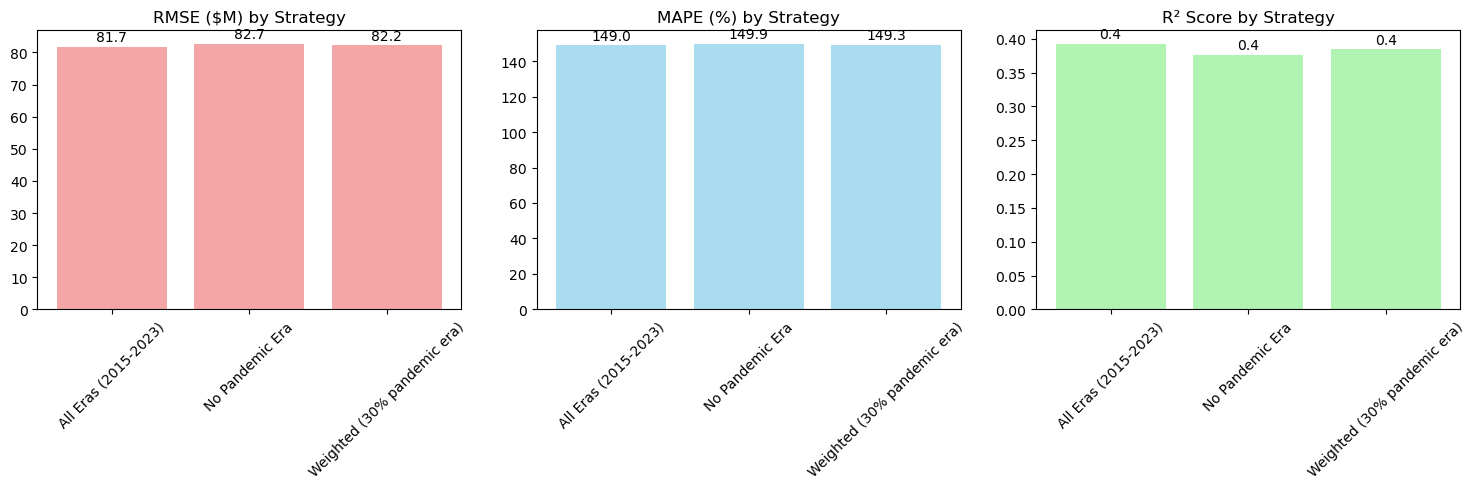

✅ Pandemic-aware model selection complete


In [7]:
# Compare strategies
print("\n📊 Strategy Comparison Results")
print("=" * 70)

strategy_comparison = pd.DataFrame([
    {
        'Strategy': r['strategy'],
        'RMSE': f"${r['rmse']:,.0f}",
        'MAE': f"${r['mae']:,.0f}",
        'MAPE': f"{r['mape']:.1f}%",
        'R²': f"{r['r2']:.3f}"
    }
    for r in strategy_results
])

print(strategy_comparison.to_string(index=False))

# Find best strategy
best_strategy_idx = min(range(len(strategy_results)), key=lambda i: strategy_results[i]['rmse'])
best_strategy = strategy_results[best_strategy_idx]

print(f"\n🏆 Best Strategy: {best_strategy['strategy']}")
print(f"   Validation RMSE: ${best_strategy['rmse']:,.0f}")
print(f"   This will be used for 2026 predictions")

# Store best model
best_model_pandemic_aware = best_strategy['model_object']

# Visualize strategy comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['rmse', 'mape', 'r2']
metric_names = ['RMSE ($M)', 'MAPE (%)', 'R² Score']
colors = ['lightcoral', 'skyblue', 'lightgreen']

for i, (metric, name, color) in enumerate(zip(metrics, metric_names, colors)):
    values = [r[metric] for r in strategy_results]
    strategies = [r['strategy'] for r in strategy_results]
    
    if metric == 'rmse':
        values = [v/1e6 for v in values]  # Convert to millions for readability
    
    bars = axes[i].bar(strategies, values, color=color, alpha=0.7)
    axes[i].set_title(f'{name} by Strategy')
    axes[i].tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{val:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("✅ Pandemic-aware model selection complete")

## 🌳 Approach 2: Decision Trees (Non-Linear Models)

**Why Decision Trees?**
- Captures non-linear relationships and feature interactions
- Naturally handles mixed data types and feature importance
- No assumption about data distribution
- Interpretable decision rules

**Experimental Design:**
- Same 3 pandemic strategies as Ridge (All Years, No Pandemic, Weighted)
- Hyperparameter tuning: max_depth, min_samples_split, min_samples_leaf, max_features
- Feature importance analysis to understand key predictors
- Compare against Ridge baseline

**Expected Outcome**: Test whether non-linear modeling improves over Ridge regression.

In [8]:

# Import Decision Tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

print("🌳 Setting up Decision Tree Regression Models")

def train_decision_tree_strategies(train_data, strategy_name, sample_weights=None):
    """Train Decision Tree models with a specific strategy"""
    print(f"🌳 Training Decision Tree - {strategy_name}")

    X_train_strat = train_data[feature_cols]
    y_train_strat = train_data[target]
    y_train_strat_log = np.log1p(y_train_strat)

    X_val = val_data[feature_cols]
    y_val = val_data[target]
    y_val_log = np.log1p(y_val)

    # Decision Tree pipeline (no scaling needed for trees)
    dt_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('dt', DecisionTreeRegressor(random_state=42))
    ])

    # Hyperparameter grid for Decision Tree
    dt_params = {
        'dt__max_depth': [5, 6, 7, 8, 9, 10],
        'dt__min_samples_split': [10, 20, 50],
        'dt__min_samples_leaf': [5, 10, 15],
        'dt__max_features': ['sqrt', 'log2', None]
    }

    dt_grid = GridSearchCV(
        dt_pipeline, dt_params, cv=5, 
        scoring='neg_mean_squared_error', n_jobs=-1
    )

    # Fit with sample weights if provided
    if sample_weights is not None:
        # GridSearchCV doesn't directly support sample weights for Decision Trees
        # We'll use best params from unweighted search, then refit with weights
        dt_grid.fit(X_train_strat, y_train_strat_log)
        best_params = dt_grid.best_params_

        # Refit with weights
        dt_weighted = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('dt', DecisionTreeRegressor(
                max_depth=best_params['dt__max_depth'],
                min_samples_split=best_params['dt__min_samples_split'],
                min_samples_leaf=best_params['dt__min_samples_leaf'],
                max_features=best_params['dt__max_features'],
                random_state=42
            ))
        ])
        dt_weighted.fit(X_train_strat, y_train_strat_log, dt__sample_weight=sample_weights)
        dt_best = dt_weighted
        print(f"  Best params: {best_params}")
    else:
        dt_grid.fit(X_train_strat, y_train_strat_log)
        dt_best = dt_grid.best_estimator_
        best_params = dt_grid.best_params_
        print(f"  Best params: {best_params}")

    # Evaluate
    results = evaluate_model(dt_best, X_val, y_val_log, y_val, f"Decision Tree - {strategy_name}")
    results['strategy'] = strategy_name
    results['model_object'] = dt_best
    results['model_type'] = 'Decision Tree'

    major_only_flag = None
    if 'is_major_studio' in train_data.columns:
        major_only_flag = bool(train_data['is_major_studio'].fillna(0).eq(1).all())

    english_only_flag = None
    if 'original_language' in train_data.columns:
        english_only_flag = bool(train_data['original_language'].fillna('').eq('en').all())

        extra_metrics = {}
    ranking_metrics = compute_ranking_metrics(
        val_data,
        results.get('predictions'),
        target_col=target,
        title_col='title',
        k=10,
    )
    if ranking_metrics:
        if 'top10_overlap' in ranking_metrics:
            results['top10_overlap'] = int(ranking_metrics['top10_overlap'])
        for key, value in ranking_metrics.items():
            if key == 'top10_overlap':
                continue
            results[key] = value
        for key, value in ranking_metrics.items():
            if value is not None:
                extra_metrics[key] = float(value)

    if MLFLOW_AVAILABLE:
            tuned_params = {k.replace('dt__', ''): v for k, v in best_params.items()}
            params_to_log = {
                'model': 'DecisionTreeRegressor',
                'uses_sample_weights': sample_weights is not None,
                'n_features': len(feature_cols),
                'train_rows': len(train_data),
                'val_rows': len(val_data),
                **tuned_params,
            }
            tags = dict(DEFAULT_MLFLOW_TAGS, strategy=strategy_name, model_family='decision_tree')
            validation_snapshot = build_validation_snapshot(val_data, target)
            log_results_to_mlflow(
                results,
                run_name=f"DecisionTree | {strategy_name}",
                params=params_to_log,
                tags=tags,
                extra_metrics=extra_metrics or None,
                feature_frame=X_val,
                validation_frame=validation_snapshot,
                dataset_major_only=major_only_flag,
                dataset_english_only=english_only_flag,
            )

    return results

print("✅ Decision Tree framework ready")


🌳 Setting up Decision Tree Regression Models
✅ Decision Tree framework ready


In [9]:
# Train Decision Tree models with all three strategies
dt_strategy_results = []

# Strategy 1: All eras including pandemic
dt_results_all = train_decision_tree_strategies(train_data_all, "All Eras (2015-2023)")
dt_strategy_results.append(dt_results_all)

# Strategy 2: Exclude pandemic era
dt_results_no_pandemic = train_decision_tree_strategies(train_data_no_pandemic, "No Pandemic Era")
dt_strategy_results.append(dt_results_no_pandemic)

# Strategy 3: Weighted approach (reduced pandemic influence)
dt_results_weighted = train_decision_tree_strategies(train_data_weighted, "Weighted (30% pandemic era)", sample_weights)
dt_strategy_results.append(dt_results_weighted)

🌳 Training Decision Tree - All Eras (2015-2023)
  Best params: {'dt__max_depth': 5, 'dt__max_features': None, 'dt__min_samples_leaf': 5, 'dt__min_samples_split': 50}

Decision Tree - All Eras (2015-2023) Performance:
  RMSE: $80,903,869
  MAE:  $34,691,065
  MAPE: 182.4%
  R²:   0.404
🌳 Training Decision Tree - No Pandemic Era
  Best params: {'dt__max_depth': 8, 'dt__max_features': None, 'dt__min_samples_leaf': 15, 'dt__min_samples_split': 50}

Decision Tree - No Pandemic Era Performance:
  RMSE: $81,430,321
  MAE:  $34,499,159
  MAPE: 161.5%
  R²:   0.396
🌳 Training Decision Tree - Weighted (30% pandemic era)
  Best params: {'dt__max_depth': 5, 'dt__max_features': None, 'dt__min_samples_leaf': 5, 'dt__min_samples_split': 50}

Decision Tree - Weighted (30% pandemic era) Performance:
  RMSE: $82,663,820
  MAE:  $35,914,749
  MAPE: 180.7%
  R²:   0.378


In [10]:
# Compare Decision Tree strategies
print("\n📊 Decision Tree Strategy Comparison")
print("=" * 70)

dt_strategy_comparison = pd.DataFrame([
    {
        'Strategy': r['strategy'],
        'RMSE': f"${r['rmse']:,.0f}",
        'MAE': f"${r['mae']:,.0f}",
        'MAPE': f"{r['mape']:.1f}%",
        'R²': f"{r['r2']:.3f}"
    }
    for r in dt_strategy_results
])

print(dt_strategy_comparison.to_string(index=False))

# Find best Decision Tree strategy
best_dt_strategy_idx = min(range(len(dt_strategy_results)), key=lambda i: dt_strategy_results[i]['rmse'])
best_dt_strategy = dt_strategy_results[best_dt_strategy_idx]

print(f"\n🏆 Best Decision Tree Strategy: {best_dt_strategy['strategy']}")
print(f"   Validation RMSE: ${best_dt_strategy['rmse']:,.0f}")

# Store best Decision Tree model
best_dt_model = best_dt_strategy['model_object']


📊 Decision Tree Strategy Comparison
                   Strategy        RMSE         MAE   MAPE    R²
       All Eras (2015-2023) $80,903,869 $34,691,065 182.4% 0.404
            No Pandemic Era $81,430,321 $34,499,159 161.5% 0.396
Weighted (30% pandemic era) $82,663,820 $35,914,749 180.7% 0.378

🏆 Best Decision Tree Strategy: All Eras (2015-2023)
   Validation RMSE: $80,903,869



🔍 Feature Importance Analysis
Top 15 Most Important Features:
                  feature  importance
          is_major_studio    0.741028
              is_ip_movie    0.140692
                is_sequel    0.021919
         is_pandemic_year    0.019982
has_immediate_competition    0.017995
   is_christmas_proximity    0.014452
          genre_animation    0.012427
                is_disney    0.008078
             genre_action    0.006163
      is_action_adventure    0.005606
             genre_horror    0.004969
                genre_war    0.003793
           genre_thriller    0.001766
          genre_adventure    0.001128
                   is_fox    0.000000


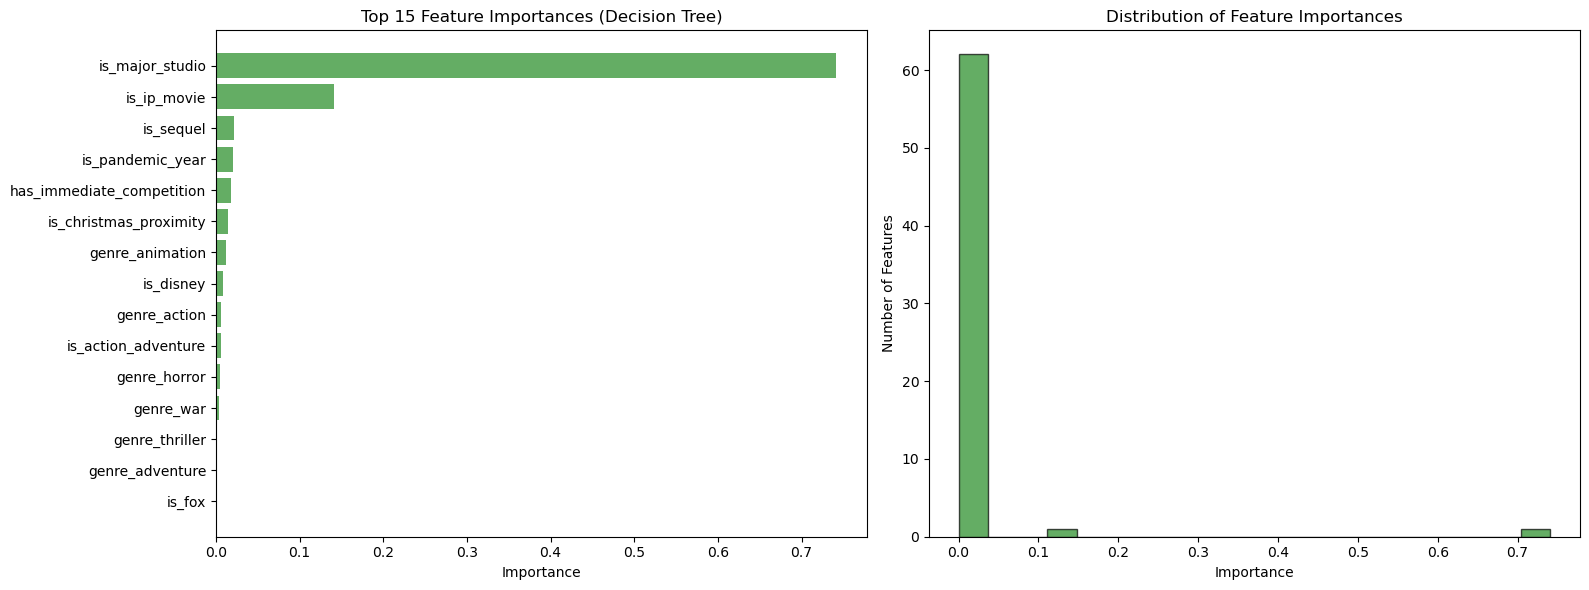


📈 Feature Analysis Summary:
   Total features: 64
   Features with importance > 0.01: 7
   Top 5 features account for: 94.2% of total importance


In [11]:
# Feature Importance Analysis (unique to Decision Trees)
print("\n🔍 Feature Importance Analysis")
print("=" * 50)

# Get feature importances from best Decision Tree model
dt_model = best_dt_model.named_steps['dt']
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

# Top 15 most important features
top_features = feature_importance.head(15)
print("Top 15 Most Important Features:")
print(top_features.to_string(index=False))

# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 15 features
axes[0].barh(top_features['feature'][::-1], top_features['importance'][::-1], color='forestgreen', alpha=0.7)
axes[0].set_title('Top 15 Feature Importances (Decision Tree)')
axes[0].set_xlabel('Importance')

# Feature importance distribution
axes[1].hist(feature_importance['importance'], bins=20, color='forestgreen', alpha=0.7, edgecolor='black')
axes[1].set_title('Distribution of Feature Importances')
axes[1].set_xlabel('Importance')
axes[1].set_ylabel('Number of Features')

plt.tight_layout()
plt.show()

print(f"\n📈 Feature Analysis Summary:")
print(f"   Total features: {len(feature_cols)}")
print(f"   Features with importance > 0.01: {(feature_importance['importance'] > 0.01).sum()}")
print(f"   Top 5 features account for: {top_features['importance'].head(5).sum():.1%} of total importance")

## 🌲 Approach 3: Random Forest (Ensemble Models)

**Why Random Forest?**
- Ensemble of decision trees reduces overfitting
- Better generalization than single decision trees
- Built-in feature importance and variance reduction
- Robust to outliers and noise

**Experimental Design:**
- Same 3 pandemic strategies as previous approaches
- Extensive hyperparameter tuning: n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features
- Feature importance analysis and comparison with Decision Tree
- Bootstrap aggregation for improved stability

**Expected Outcome**: Test whether ensemble methods provide the best performance for box office prediction.

In [12]:

# Import Random Forest
from sklearn.ensemble import RandomForestRegressor

print("🌲 Setting up Random Forest Regression Models")

def train_random_forest_strategies(train_data, strategy_name, sample_weights=None):
    """Train Random Forest models with a specific strategy"""
    print(f"🌲 Training Random Forest - {strategy_name}")

    X_train_strat = train_data[feature_cols]
    y_train_strat = train_data[target]
    y_train_strat_log = np.log1p(y_train_strat)

    X_val = val_data[feature_cols]
    y_val = val_data[target]
    y_val_log = np.log1p(y_val)

    # Random Forest pipeline (no scaling needed for tree-based models)
    rf_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
    ])

    # Hyperparameter grid for Random Forest
    rf_params = {
        'rf__n_estimators': [100, 150, 200],  # Start with 100 as requested
        'rf__max_depth': [6, 8, 10, 12, None],
        'rf__min_samples_split': [10, 20, 50],
        'rf__min_samples_leaf': [5, 10, 15],
        'rf__max_features': ['sqrt', 'log2', 0.3]
    }

    rf_grid = GridSearchCV(
        rf_pipeline, rf_params, cv=5, 
        scoring='neg_mean_squared_error', n_jobs=-1, verbose=1
    )

    # Fit with sample weights if provided
    if sample_weights is not None:
        # GridSearchCV doesn't directly support sample weights for Random Forest
        # We'll use best params from unweighted search, then refit with weights
        print("  Running hyperparameter search...")
        rf_grid.fit(X_train_strat, y_train_strat_log)
        best_params = rf_grid.best_params_

        # Refit with weights
        print("  Refitting with sample weights...")
        rf_weighted = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('rf', RandomForestRegressor(
                n_estimators=best_params['rf__n_estimators'],
                max_depth=best_params['rf__max_depth'],
                min_samples_split=best_params['rf__min_samples_split'],
                min_samples_leaf=best_params['rf__min_samples_leaf'],
                max_features=best_params['rf__max_features'],
                random_state=42,
                n_jobs=-1
            ))
        ])
        rf_weighted.fit(X_train_strat, y_train_strat_log, rf__sample_weight=sample_weights)
        rf_best = rf_weighted
        print(f"  Best params: {best_params}")
    else:
        print("  Running hyperparameter search...")
        rf_grid.fit(X_train_strat, y_train_strat_log)
        rf_best = rf_grid.best_estimator_
        best_params = rf_grid.best_params_
        print(f"  Best params: {best_params}")

    # Evaluate
    results = evaluate_model(rf_best, X_val, y_val_log, y_val, f"Random Forest - {strategy_name}")
    results['strategy'] = strategy_name
    results['model_object'] = rf_best
    results['model_type'] = 'Random Forest'

    major_only_flag = None
    if 'is_major_studio' in train_data.columns:
        major_only_flag = bool(train_data['is_major_studio'].fillna(0).eq(1).all())

    english_only_flag = None
    if 'original_language' in train_data.columns:
        english_only_flag = bool(train_data['original_language'].fillna('').eq('en').all())

        extra_metrics = {}
    ranking_metrics = compute_ranking_metrics(
        val_data,
        results.get('predictions'),
        target_col=target,
        title_col='title',
        k=10,
    )
    if ranking_metrics:
        if 'top10_overlap' in ranking_metrics:
            results['top10_overlap'] = int(ranking_metrics['top10_overlap'])
        for key, value in ranking_metrics.items():
            if key == 'top10_overlap':
                continue
            results[key] = value
        for key, value in ranking_metrics.items():
            if value is not None:
                extra_metrics[key] = float(value)

    if MLFLOW_AVAILABLE:
            tuned_params = {k.replace('rf__', ''): v for k, v in best_params.items()}
            params_to_log = {
                'model': 'RandomForestRegressor',
                'uses_sample_weights': sample_weights is not None,
                'n_features': len(feature_cols),
                'train_rows': len(train_data),
                'val_rows': len(val_data),
                **tuned_params,
            }
            tags = dict(DEFAULT_MLFLOW_TAGS, strategy=strategy_name, model_family='random_forest')
            validation_snapshot = build_validation_snapshot(val_data, target)
            log_results_to_mlflow(
                results,
                run_name=f"RandomForest | {strategy_name}",
                params=params_to_log,
                tags=tags,
                extra_metrics=extra_metrics or None,
                feature_frame=X_val,
                validation_frame=validation_snapshot,
                dataset_major_only=major_only_flag,
                dataset_english_only=english_only_flag,
            )

    return results

print("✅ Random Forest framework ready")


🌲 Setting up Random Forest Regression Models
✅ Random Forest framework ready


In [13]:
# Train Random Forest models with all three strategies 
print("🎯 Training Random Forest Models")

rf_strategy_results = []

# Strategy 1: All eras including pandemic
rf_results_all = train_random_forest_strategies(train_data_all, "All Eras (2015-2023)")
rf_strategy_results.append(rf_results_all)

# Strategy 2: Exclude pandemic era
rf_results_no_pandemic = train_random_forest_strategies(train_data_no_pandemic, "No Pandemic Era")
rf_strategy_results.append(rf_results_no_pandemic)

# Strategy 3: Weighted approach (reduced pandemic influence)
rf_results_weighted = train_random_forest_strategies(train_data_weighted, "Weighted (30% pandemic era)", sample_weights)
rf_strategy_results.append(rf_results_weighted)

🎯 Training Random Forest Models
🌲 Training Random Forest - All Eras (2015-2023)
  Running hyperparameter search...
Fitting 5 folds for each of 405 candidates, totalling 2025 fits
  Best params: {'rf__max_depth': 8, 'rf__max_features': 0.3, 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 20, 'rf__n_estimators': 150}

Random Forest - All Eras (2015-2023) Performance:
  RMSE: $84,672,554
  MAE:  $35,156,886
  MAPE: 171.1%
  R²:   0.347
🌲 Training Random Forest - No Pandemic Era
  Running hyperparameter search...
Fitting 5 folds for each of 405 candidates, totalling 2025 fits
  Best params: {'rf__max_depth': None, 'rf__max_features': 0.3, 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 10, 'rf__n_estimators': 150}

Random Forest - No Pandemic Era Performance:
  RMSE: $83,841,416
  MAE:  $35,292,102
  MAPE: 174.1%
  R²:   0.360
🌲 Training Random Forest - Weighted (30% pandemic era)
  Running hyperparameter search...
Fitting 5 folds for each of 405 candidates, totalling 2025 fits
  R

In [14]:
# Compare Random Forest strategies
print("\n📊 Random Forest Strategy Comparison")
print("=" * 70)

rf_strategy_comparison = pd.DataFrame([
    {
        'Strategy': r['strategy'],
        'RMSE': f"${r['rmse']:,.0f}",
        'MAE': f"${r['mae']:,.0f}",
        'MAPE': f"{r['mape']:.1f}%",
        'R²': f"{r['r2']:.3f}"
    }
    for r in rf_strategy_results
])

print(rf_strategy_comparison.to_string(index=False))

# Find best Random Forest strategy
best_rf_strategy_idx = min(range(len(rf_strategy_results)), key=lambda i: rf_strategy_results[i]['rmse'])
best_rf_strategy = rf_strategy_results[best_rf_strategy_idx]

print(f"\n🏆 Best Random Forest Strategy: {best_rf_strategy['strategy']}")
print(f"   Validation RMSE: ${best_rf_strategy['rmse']:,.0f}")

# Store best Random Forest model
best_rf_model = best_rf_strategy['model_object']


📊 Random Forest Strategy Comparison
                   Strategy        RMSE         MAE   MAPE    R²
       All Eras (2015-2023) $84,672,554 $35,156,886 171.1% 0.347
            No Pandemic Era $83,841,416 $35,292,102 174.1% 0.360
Weighted (30% pandemic era) $83,924,413 $35,092,872 171.4% 0.359

🏆 Best Random Forest Strategy: No Pandemic Era
   Validation RMSE: $83,841,416



🔍 Random Forest Feature Importance Analysis
Top 15 Most Important Features (Random Forest):
                    feature  importance
            is_major_studio    0.440968
                is_ip_movie    0.087097
            genre_adventure    0.050395
                  is_sequel    0.046421
                genre_drama    0.043134
              release_month    0.029594
nearby_major_releases_count    0.024310
       years_since_baseline    0.022153
                  is_disney    0.016110
             is_warner_bros    0.015992
               is_universal    0.014884
            days_to_holiday    0.014883
               genre_action    0.013568
                genre_count    0.012683
            is_sequel_title    0.011601


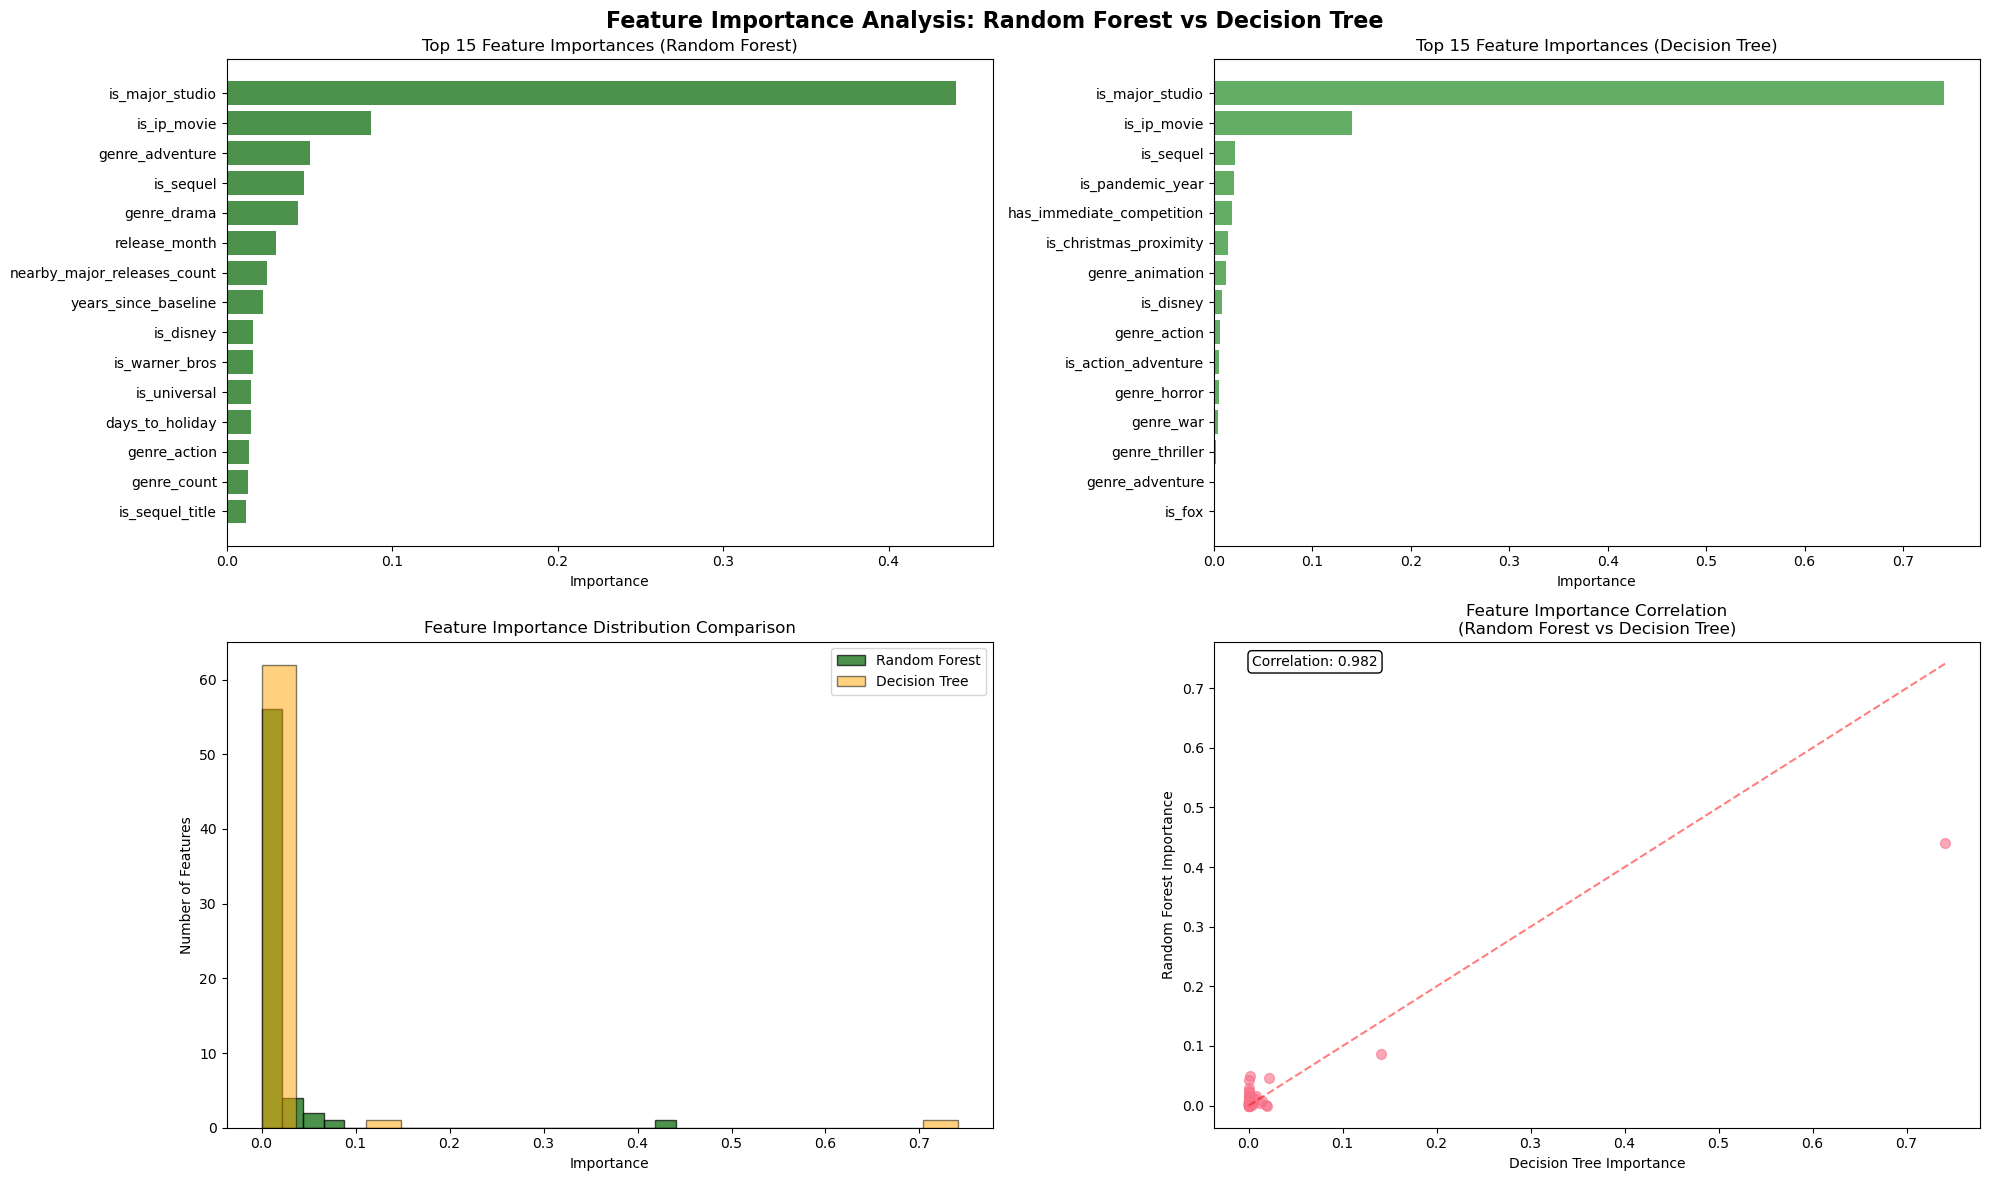


📈 Random Forest Feature Analysis Summary:
   Total features: 64
   Features with importance > 0.01: 16
   Top 5 features account for: 66.8% of total importance
   RF vs DT feature importance correlation: 0.982

🔄 Feature Ranking Differences (RF vs DT):
Top 10 features with largest ranking differences:
                    feature  rf_rank  dt_rank  rank_diff
           is_pandemic_year       63        3         60
       years_since_baseline        7       60         53
  has_immediate_competition       53        4         49
                  genre_war       47       11         36
nearby_major_releases_count        6       42         36
            is_sequel_title       14       50         36
            days_to_holiday       11       45         34
              genre_western       59       26         33
               is_superhero       23       56         33
       is_pre_streaming_era       30       61         31


In [15]:
# Random Forest Feature Importance Analysis
print("\n🔍 Random Forest Feature Importance Analysis")
print("=" * 60)

# Get feature importances from best Random Forest model
rf_model = best_rf_model.named_steps['rf']
rf_feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Top 15 most important features
rf_top_features = rf_feature_importance.head(15)
print("Top 15 Most Important Features (Random Forest):")
print(rf_top_features.to_string(index=False))

# Compare with Decision Tree feature importance
dt_model = best_dt_model.named_steps['dt']
dt_feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

# Visualize feature importance comparison
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Feature Importance Analysis: Random Forest vs Decision Tree', fontsize=16, fontweight='bold')

# Top 15 Random Forest features
axes[0,0].barh(rf_top_features['feature'][::-1], rf_top_features['importance'][::-1], 
               color='darkgreen', alpha=0.7)
axes[0,0].set_title('Top 15 Feature Importances (Random Forest)')
axes[0,0].set_xlabel('Importance')

# Top 15 Decision Tree features (for comparison)
dt_top_features = dt_feature_importance.head(15)
axes[0,1].barh(dt_top_features['feature'][::-1], dt_top_features['importance'][::-1], 
               color='forestgreen', alpha=0.7)
axes[0,1].set_title('Top 15 Feature Importances (Decision Tree)')
axes[0,1].set_xlabel('Importance')

# Feature importance distribution comparison
axes[1,0].hist(rf_feature_importance['importance'], bins=20, alpha=0.7, 
               color='darkgreen', label='Random Forest', edgecolor='black')
axes[1,0].hist(dt_feature_importance['importance'], bins=20, alpha=0.5, 
               color='orange', label='Decision Tree', edgecolor='black')
axes[1,0].set_title('Feature Importance Distribution Comparison')
axes[1,0].set_xlabel('Importance')
axes[1,0].set_ylabel('Number of Features')
axes[1,0].legend()

# Feature importance correlation between models
# Create merged dataframe for comparison
importance_comparison = pd.merge(
    rf_feature_importance[['feature', 'importance']].rename(columns={'importance': 'rf_importance'}),
    dt_feature_importance[['feature', 'importance']].rename(columns={'importance': 'dt_importance'}),
    on='feature'
)

axes[1,1].scatter(importance_comparison['dt_importance'], importance_comparison['rf_importance'], 
                 alpha=0.6, s=50)
axes[1,1].set_xlabel('Decision Tree Importance')
axes[1,1].set_ylabel('Random Forest Importance')
axes[1,1].set_title('Feature Importance Correlation\n(Random Forest vs Decision Tree)')

# Add diagonal line
max_importance = max(importance_comparison['dt_importance'].max(), 
                    importance_comparison['rf_importance'].max())
axes[1,1].plot([0, max_importance], [0, max_importance], 'r--', alpha=0.5)

# Calculate correlation
correlation = importance_comparison['dt_importance'].corr(importance_comparison['rf_importance'])
axes[1,1].text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
               transform=axes[1,1].transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="white"))

plt.tight_layout()
plt.show()

print(f"\n📈 Random Forest Feature Analysis Summary:")
print(f"   Total features: {len(feature_cols)}")
print(f"   Features with importance > 0.01: {(rf_feature_importance['importance'] > 0.01).sum()}")
print(f"   Top 5 features account for: {rf_top_features['importance'].head(5).sum():.1%} of total importance")
print(f"   RF vs DT feature importance correlation: {correlation:.3f}")

# Show top features that differ between models
print(f"\n🔄 Feature Ranking Differences (RF vs DT):")
rf_ranks = {feat: i for i, feat in enumerate(rf_feature_importance['feature'])}
dt_ranks = {feat: i for i, feat in enumerate(dt_feature_importance['feature'])}

rank_differences = []
for feat in feature_cols:
    rf_rank = rf_ranks[feat]
    dt_rank = dt_ranks[feat]
    rank_diff = abs(rf_rank - dt_rank)
    rank_differences.append({'feature': feat, 'rf_rank': rf_rank, 'dt_rank': dt_rank, 'rank_diff': rank_diff})

rank_differences = pd.DataFrame(rank_differences).sort_values('rank_diff', ascending=False)
print("Top 10 features with largest ranking differences:")
print(rank_differences.head(10)[['feature', 'rf_rank', 'dt_rank', 'rank_diff']].to_string(index=False))

## 🚀 Approach 4: XGBoost (Gradient Boosting)

**Why XGBoost?**
- State-of-the-art gradient boosting framework
- Excellent performance on structured/tabular data
- Built-in regularization and feature importance
- Handles missing values automatically
- Often wins machine learning competitions

**Experimental Design:**
- Same 3 pandemic strategies as previous approaches
- Extensive hyperparameter tuning: n_estimators, max_depth, learning_rate, subsample, colsample_bytree
- Feature importance analysis and comparison with tree-based models
- Built-in cross-validation for early stopping

**Expected Outcome**: Test whether gradient boosting provides superior performance for box office prediction.

In [16]:
if XGBOOST_AVAILABLE:
    print("🚀 Setting up XGBoost Regression Models")

    def train_xgboost_strategies(train_data, strategy_name, sample_weights=None):
        """Train XGBoost models with a specific strategy"""
        print(f"🚀 Training XGBoost - {strategy_name}")

        X_train_strat = train_data[feature_cols]
        y_train_strat = train_data[target]
        y_train_strat_log = np.log1p(y_train_strat)

        X_val = val_data[feature_cols]
        y_val = val_data[target]
        y_val_log = np.log1p(y_val)

        # XGBoost pipeline
        xgb_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('xgb', xgb.XGBRegressor(random_state=42, verbosity=0))
        ])

        # Hyperparameter grid
        xgb_params = {
            'xgb__n_estimators': [100, 200, 300],
            'xgb__max_depth': [3, 4, 5, 6],
            'xgb__learning_rate': [0.01, 0.05, 0.1, 0.2],
            'xgb__subsample': [0.8, 0.9, 1.0],
            'xgb__colsample_bytree': [0.8, 0.9, 1.0]
        }

        xgb_grid = GridSearchCV(
            xgb_pipeline, xgb_params, cv=5, 
            scoring='neg_mean_squared_error', n_jobs=-1, verbose=1
        )

        # Fit with or without sample weights
        if sample_weights is not None:
            print("  Running hyperparameter search...")
            xgb_grid.fit(X_train_strat, y_train_strat_log)
            best_params = xgb_grid.best_params_

            print("  Refitting with sample weights...")
            xgb_weighted = Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('xgb', xgb.XGBRegressor(
                    n_estimators=best_params['xgb__n_estimators'],
                    max_depth=best_params['xgb__max_depth'],
                    learning_rate=best_params['xgb__learning_rate'],
                    subsample=best_params['xgb__subsample'],
                    colsample_bytree=best_params['xgb__colsample_bytree'],
                    random_state=42,
                    verbosity=0
                ))
            ])
            xgb_weighted.fit(X_train_strat, y_train_strat_log, xgb__sample_weight=sample_weights)
            xgb_best = xgb_weighted
            print(f"  Best params: {best_params}")
        else:
            print("  Running hyperparameter search...")
            xgb_grid.fit(X_train_strat, y_train_strat_log)
            xgb_best = xgb_grid.best_estimator_
            best_params = xgb_grid.best_params_
            print(f"  Best params: {best_params}")

        # Evaluate
        results = evaluate_model(xgb_best, X_val, y_val_log, y_val, f"XGBoost - {strategy_name}")
        results['strategy'] = strategy_name
        results['model_object'] = xgb_best
        results['model_type'] = 'XGBoost'

        major_only_flag = None
        if 'is_major_studio' in train_data.columns:
            major_only_flag = bool(train_data['is_major_studio'].fillna(0).eq(1).all())

        english_only_flag = None
        if 'original_language' in train_data.columns:
            english_only_flag = bool(train_data['original_language'].fillna('').eq('en').all())

        extra_metrics = {}
        ranking_metrics = compute_ranking_metrics(
            val_data,
            results.get('predictions'),
            target_col=target,
            title_col='title',
            k=10,
        )
        if ranking_metrics:
            if 'top10_overlap' in ranking_metrics:
                results['top10_overlap'] = int(ranking_metrics['top10_overlap'])
            for key, value in ranking_metrics.items():
                if key == 'top10_overlap':
                    continue
                results[key] = value
            for key, value in ranking_metrics.items():
                if value is not None:
                    extra_metrics[key] = float(value)

        if MLFLOW_AVAILABLE:
            tuned_params = {k.replace('xgb__', ''): v for k, v in best_params.items()}
            params_to_log = {
                'model': 'XGBRegressor',
                'uses_sample_weights': sample_weights is not None,
                'n_features': len(feature_cols),
                'train_rows': len(train_data),
                'val_rows': len(val_data),
                **tuned_params,
            }
            tags = dict(DEFAULT_MLFLOW_TAGS, strategy=strategy_name, model_family='xgboost')
            validation_snapshot = build_validation_snapshot(val_data, target)
            log_results_to_mlflow(
                results,
                run_name=f"XGBoost | {strategy_name}",
                params=params_to_log,
                tags=tags,
                extra_metrics=extra_metrics or None,
                feature_frame=X_val,
                validation_frame=validation_snapshot,
                dataset_major_only=major_only_flag,
                dataset_english_only=english_only_flag,
            )

        return results  # ✅ correctly indented inside the function

    print("✅ XGBoost framework ready")
else:
    print("❌ XGBoost not available - skipping XGBoost experiments")
    print("   Install with: pip install xgboost")


🚀 Setting up XGBoost Regression Models
✅ XGBoost framework ready


In [17]:
if XGBOOST_AVAILABLE:
    # Train XGBoost models with all three strategies 
    print("🎯 Training XGBoost Models")

    xgb_strategy_results = []

    # Strategy 1: All eras including pandemic
    xgb_results_all = train_xgboost_strategies(train_data_all, "All Eras (2015-2023)")
    xgb_strategy_results.append(xgb_results_all)

    # Strategy 2: Exclude pandemic era
    xgb_results_no_pandemic = train_xgboost_strategies(train_data_no_pandemic, "No Pandemic Era")
    xgb_strategy_results.append(xgb_results_no_pandemic)

    # Strategy 3: Weighted approach (reduced pandemic influence)
    xgb_results_weighted = train_xgboost_strategies(train_data_weighted, "Weighted (30% pandemic era)", sample_weights)
    xgb_strategy_results.append(xgb_results_weighted)
    
    # Compare XGBoost strategies
    print("\n📊 XGBoost Strategy Comparison")
    print("=" * 70)

    xgb_strategy_comparison = pd.DataFrame([
        {
            'Strategy': r['strategy'],
            'RMSE': f"${r['rmse']:,.0f}",
            'MAE': f"${r['mae']:,.0f}",
            'MAPE': f"{r['mape']:.1f}%",
            'R²': f"{r['r2']:.3f}"
        }
        for r in xgb_strategy_results
    ])

    print(xgb_strategy_comparison.to_string(index=False))

    # Find best XGBoost strategy
    best_xgb_strategy_idx = min(range(len(xgb_strategy_results)), key=lambda i: xgb_strategy_results[i]['rmse'])
    best_xgb_strategy = xgb_strategy_results[best_xgb_strategy_idx]

    print(f"\n🏆 Best XGBoost Strategy: {best_xgb_strategy['strategy']}")
    print(f"   Validation RMSE: ${best_xgb_strategy['rmse']:,.0f}")

    # Store best XGBoost model
    best_xgb_model = best_xgb_strategy['model_object']
else:
    print("❌ XGBoost not available - creating empty results")
    xgb_strategy_results = []

🎯 Training XGBoost Models
🚀 Training XGBoost - All Eras (2015-2023)
  Running hyperparameter search...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
  Best params: {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.05, 'xgb__max_depth': 3, 'xgb__n_estimators': 200, 'xgb__subsample': 1.0}

XGBoost - All Eras (2015-2023) Performance:
  RMSE: $79,061,450
  MAE:  $32,901,988
  MAPE: 153.4%
  R²:   0.431
🚀 Training XGBoost - No Pandemic Era
  Running hyperparameter search...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
  Best params: {'xgb__colsample_bytree': 0.9, 'xgb__learning_rate': 0.05, 'xgb__max_depth': 3, 'xgb__n_estimators': 100, 'xgb__subsample': 0.9}

XGBoost - No Pandemic Era Performance:
  RMSE: $80,520,192
  MAE:  $33,888,417
  MAPE: 162.2%
  R²:   0.410
🚀 Training XGBoost - Weighted (30% pandemic era)
  Running hyperparameter search...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
  Refitting with sample weights...
  B

## 💡 Approach 5: LightGBM (Fast Gradient Boosting)

**Why LightGBM?**
- Microsoft's high-performance gradient boosting framework
- Faster training than XGBoost with similar accuracy
- Built-in categorical feature handling
- Memory efficient and scalable
- Often comparable or superior to XGBoost

**Experimental Design:**
- Same 3 pandemic strategies as previous approaches
- Hyperparameter tuning: n_estimators, max_depth, learning_rate, num_leaves, feature_fraction
- Feature importance analysis and comparison with other tree-based models
- Early stopping to prevent overfitting

**Expected Outcome**: Compare LightGBM performance against XGBoost and other models.

In [18]:
# ============================================
# LightGBM: RandomizedSearchCV + Early Stopping
# ============================================
if LIGHTGBM_AVAILABLE:
    print("💡 Setting up LightGBM Regression Models (RandomizedSearchCV)")

    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import RandomizedSearchCV

    LGB_N_ITER = 40
    LGB_CV_FOLDS = 5
    LGB_ES_ROUNDS = 100
    LGB_RANDOM_STATE = 42

    def train_lightgbm_strategies(train_data, strategy_name, sample_weights=None):
        """Train LightGBM models with a specific strategy (RandomizedSearchCV)"""
        print(f"💡 Training LightGBM - {strategy_name}")

        # Split
        X_train_strat = train_data[feature_cols]
        y_train_strat = train_data[target]
        y_train_strat_log = np.log1p(y_train_strat)

        X_val = val_data[feature_cols]
        y_val = val_data[target]
        y_val_log = np.log1p(y_val)

        # Pipeline
        lgb_pipeline = Pipeline([
            ('lgb', lgb.LGBMRegressor(
                random_state=LGB_RANDOM_STATE,
                verbosity=-1,
                n_jobs=1
            ))
        ])

        # Search space
        lgb_param_dist = {
            'lgb__n_estimators': [500, 1000, 1500, 2000],
            'lgb__learning_rate': [0.02, 0.03, 0.05, 0.08],
            'lgb__num_leaves': [63, 95, 127, 191],
            'lgb__min_child_samples': [20, 50, 100, 200],
            'lgb__max_depth': [-1],
            'lgb__feature_fraction': [0.7, 0.8, 0.9, 1.0],
            'lgb__bagging_fraction': [0.7, 0.8, 0.9, 1.0],
            'lgb__bagging_freq': [1],
            'lgb__reg_lambda': [0.0, 1.0, 5.0, 10.0],
            'lgb__reg_alpha': [0.0, 0.1, 0.5, 1.0],
            'lgb__min_split_gain': [0.0, 0.05, 0.1]
        }

        lgb_rand = RandomizedSearchCV(
            estimator=lgb_pipeline,
            param_distributions=lgb_param_dist,
            n_iter=LGB_N_ITER,
            cv=LGB_CV_FOLDS,
            scoring='neg_mean_squared_error',
            n_jobs=-1,
            verbose=1,
            random_state=LGB_RANDOM_STATE
        )

        # Early stopping
        es_cb = lgb.early_stopping(stopping_rounds=LGB_ES_ROUNDS, verbose=False)
        fit_kwargs = {
            'lgb__eval_set': [(X_val, y_val_log)],
            'lgb__eval_metric': 'rmse',
            'lgb__callbacks': [es_cb]
        }

        print("  Running randomized search...")
        if sample_weights is None:
            lgb_rand.fit(X_train_strat, y_train_strat_log, **fit_kwargs)
            lgb_best = lgb_rand.best_estimator_
            best_params = lgb_rand.best_params_
            print(f"  Best params: {best_params}")
        else:
            lgb_rand.fit(X_train_strat, y_train_strat_log, **fit_kwargs)
            best_params = lgb_rand.best_params_
            print(f"  Best params: {best_params}")

            print("  Refitting with sample weights...")
            lgb_weighted = Pipeline([
                ('lgb', lgb.LGBMRegressor(
                    n_estimators=best_params['lgb__n_estimators'],
                    learning_rate=best_params['lgb__learning_rate'],
                    num_leaves=best_params['lgb__num_leaves'],
                    min_child_samples=best_params['lgb__min_child_samples'],
                    max_depth=best_params['lgb__max_depth'],
                    feature_fraction=best_params['lgb__feature_fraction'],
                    bagging_fraction=best_params['lgb__bagging_fraction'],
                    bagging_freq=best_params['lgb__bagging_freq'],
                    reg_lambda=best_params['lgb__reg_lambda'],
                    reg_alpha=best_params['lgb__reg_alpha'],
                    min_split_gain=best_params['lgb__min_split_gain'],
                    random_state=LGB_RANDOM_STATE,
                    verbosity=-1,
                    n_jobs=1
                ))
            ])
            lgb_weighted.fit(
                X_train_strat, y_train_strat_log,
                lgb__sample_weight=sample_weights,
                **fit_kwargs
            )
            lgb_best = lgb_weighted

        # Evaluate
        results = evaluate_model(lgb_best, X_val, y_val_log, y_val, f"LightGBM - {strategy_name}")
        results['strategy'] = strategy_name
        results['model_object'] = lgb_best
        results['model_type'] = 'LightGBM'

        major_only_flag = None
        if 'is_major_studio' in train_data.columns:
            major_only_flag = bool(train_data['is_major_studio'].fillna(0).eq(1).all())

        english_only_flag = None
        if 'original_language' in train_data.columns:
            english_only_flag = bool(train_data['original_language'].fillna('').eq('en').all())

        extra_metrics = {}
        ranking_metrics = compute_ranking_metrics(
            val_data,
            results.get('predictions'),
            target_col=target,
            title_col='title',
            k=10,
        )
        if ranking_metrics:
            if 'top10_overlap' in ranking_metrics:
                results['top10_overlap'] = int(ranking_metrics['top10_overlap'])
            for key, value in ranking_metrics.items():
                if key == 'top10_overlap':
                    continue
                results[key] = value
            for key, value in ranking_metrics.items():
                if value is not None:
                    extra_metrics[key] = float(value)

        if MLFLOW_AVAILABLE:
            tuned_params = {k.replace('lgb__', ''): v for k, v in best_params.items()}
            params_to_log = {
                'model': 'LGBMRegressor',
                'uses_sample_weights': sample_weights is not None,
                'n_features': len(feature_cols),
                'train_rows': len(train_data),
                'val_rows': len(val_data),
                **tuned_params,
            }
            tags = dict(DEFAULT_MLFLOW_TAGS, strategy=strategy_name, model_family='lightgbm')
            validation_snapshot = build_validation_snapshot(val_data, target)
            log_results_to_mlflow(
                results,
                run_name=f"LightGBM | {strategy_name}",
                params=params_to_log,
                tags=tags,
                extra_metrics=extra_metrics or None,
                feature_frame=X_val,
                validation_frame=validation_snapshot,
                dataset_major_only=major_only_flag,
                dataset_english_only=english_only_flag,
            )

        return results  # ✅ correctly indented inside the function

    print("✅ LightGBM (Randomized) framework ready")
else:
    print("❌ LightGBM not available - skipping LightGBM experiments")
    print("   Install with: pip install lightgbm")


💡 Setting up LightGBM Regression Models (RandomizedSearchCV)
✅ LightGBM (Randomized) framework ready


In [19]:
# =========================
# Run the LightGBM strategies
# =========================
if LIGHTGBM_AVAILABLE:
    print("🎯 Training LightGBM Models (RandomizedSearchCV)")

    lgb_strategy_results = []

    # Strategy 1: All eras including pandemic
    lgb_results_all = train_lightgbm_strategies(train_data_all, "All Eras (2015-2023)")
    lgb_strategy_results.append(lgb_results_all)

    # Strategy 2: Exclude pandemic era
    lgb_results_no_pandemic = train_lightgbm_strategies(train_data_no_pandemic, "No Pandemic Era")
    lgb_strategy_results.append(lgb_results_no_pandemic)

    # Strategy 3: Weighted approach (reduced pandemic influence)
    lgb_results_weighted = train_lightgbm_strategies(
        train_data_weighted,
        "Weighted (30% pandemic era)",
        sample_weights
    )
    lgb_strategy_results.append(lgb_results_weighted)

    # Compare strategies
    print("\n📊 LightGBM Strategy Comparison")
    print("=" * 70)
    lgb_strategy_comparison = pd.DataFrame([
        {
            'Strategy': r['strategy'],
            'RMSE': f"${r['rmse']:,.0f}",
            'MAE': f"${r['mae']:,.0f}",
            'MAPE': f"{r['mape']:.1f}%",
            'R²': f"{r['r2']:.3f}"
        }
        for r in lgb_strategy_results
    ])
    print(lgb_strategy_comparison.to_string(index=False))

    # Pick best
    best_lgb_strategy_idx = min(
        range(len(lgb_strategy_results)),
        key=lambda i: lgb_strategy_results[i]['rmse']
    )
    best_lgb_strategy = lgb_strategy_results[best_lgb_strategy_idx]

    print(f"\n🏆 Best LightGBM Strategy: {best_lgb_strategy['strategy']}")
    print(f"   Validation RMSE: ${best_lgb_strategy['rmse']:,.0f}")

    # Store best model
    best_lgb_model = best_lgb_strategy['model_object']
else:
    print("❌ LightGBM not available - creating empty results")
    lgb_strategy_results = []


🎯 Training LightGBM Models (RandomizedSearchCV)
💡 Training LightGBM - All Eras (2015-2023)
  Running randomized search...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
  Best params: {'lgb__reg_lambda': 10.0, 'lgb__reg_alpha': 0.5, 'lgb__num_leaves': 95, 'lgb__n_estimators': 2000, 'lgb__min_split_gain': 0.1, 'lgb__min_child_samples': 50, 'lgb__max_depth': -1, 'lgb__learning_rate': 0.05, 'lgb__feature_fraction': 0.9, 'lgb__bagging_freq': 1, 'lgb__bagging_fraction': 0.9}

LightGBM - All Eras (2015-2023) Performance:
  RMSE: $76,828,355
  MAE:  $32,286,430
  MAPE: 165.7%
  R²:   0.462
💡 Training LightGBM - No Pandemic Era
  Running randomized search...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
  Best params: {'lgb__reg_lambda': 5.0, 'lgb__reg_alpha': 0.5, 'lgb__num_leaves': 191, 'lgb__n_estimators': 500, 'lgb__min_split_gain': 0.0, 'lgb__min_child_samples': 20, 'lgb__max_depth': -1, 'lgb__learning_rate': 0.08, 'lgb__feature_fraction': 0.7, 'lgb__bagging

In [20]:
# Save best models from each approach for comparison in notebook 5
import pickle
import os

print("💾 Saving Best Models for Final Comparison")
print("=" * 60)

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Collect all available results
all_available_results = []

# Find best Ridge model
best_ridge_idx = min(range(len(strategy_results)), key=lambda i: strategy_results[i]['rmse'])
best_ridge = strategy_results[best_ridge_idx]
all_available_results.append(('ridge', best_ridge))

# Find best Decision Tree model  
best_dt_idx = min(range(len(dt_strategy_results)), key=lambda i: dt_strategy_results[i]['rmse'])
best_dt = dt_strategy_results[best_dt_idx]
all_available_results.append(('decision_tree', best_dt))

# Find best Random Forest model
best_rf_idx = min(range(len(rf_strategy_results)), key=lambda i: rf_strategy_results[i]['rmse'])
best_rf = rf_strategy_results[best_rf_idx]
all_available_results.append(('random_forest', best_rf))

# Find best XGBoost model (if available)
if XGBOOST_AVAILABLE and len(xgb_strategy_results) > 0:
    best_xgb_idx = min(range(len(xgb_strategy_results)), key=lambda i: xgb_strategy_results[i]['rmse'])
    best_xgb = xgb_strategy_results[best_xgb_idx]
    all_available_results.append(('xgboost', best_xgb))

# Find best LightGBM model (if available)
if LIGHTGBM_AVAILABLE and len(lgb_strategy_results) > 0:
    best_lgb_idx = min(range(len(lgb_strategy_results)), key=lambda i: lgb_strategy_results[i]['rmse'])
    best_lgb = lgb_strategy_results[best_lgb_idx]
    all_available_results.append(('lightgbm', best_lgb))

# Save best models and their metadata
models_to_save = {}
for model_name, best_result in all_available_results:
    models_to_save[model_name] = {
        'model': best_result['model_object'],
        'strategy': best_result['strategy'],
        'rmse': best_result['rmse'],
        'mae': best_result['mae'],
        'mape': best_result['mape'],
        'r2': best_result['r2'],
        'type': best_result.get('model_type', model_name.replace('_', ' ').title())
    }

# Save each model
for model_name, model_data in models_to_save.items():
    with open(f'../models/best_{model_name}_model.pkl', 'wb') as f:
        pickle.dump(model_data, f)
    
    print(f"✅ Saved {model_data['type']} ({model_data['strategy']})")
    print(f"   RMSE: ${model_data['rmse']:,.0f}, R²: {model_data['r2']:.3f}")

# Save feature columns for consistency
with open('../models/feature_columns.pkl', 'wb') as f:
    pickle.dump(feature_cols, f)

print(f"\n📁 Models saved to ../models/ directory")
saved_models = [f"best_{name}_model.pkl" for name in models_to_save.keys()]
for model_file in saved_models:
    print(f"   • {model_file}")
print(f"   • feature_columns.pkl")

print(f"\n🔄 Use these models in notebook 5 for final comparison")
print(f"📊 Total models available: {len(models_to_save)}")

# Show quick comparison of all models
if len(models_to_save) > 1:
    print(f"\n🏆 Quick Model Comparison (Best RMSE):")
    comparison_list = [(name, data['rmse'], data['r2']) for name, data in models_to_save.items()]
    comparison_list.sort(key=lambda x: x[1])  # Sort by RMSE
    
    for i, (name, rmse, r2) in enumerate(comparison_list, 1):
        print(f"   {i}. {name.replace('_', ' ').title()}: RMSE ${rmse:,.0f}, R² {r2:.3f}")
    
    best_overall = comparison_list[0]
    print(f"\n🥇 Overall Best: {best_overall[0].replace('_', ' ').title()}")
    print(f"   RMSE: ${best_overall[1]:,.0f}")
    print(f"   R²: {best_overall[2]:.3f}")

💾 Saving Best Models for Final Comparison
✅ Saved Ridge (All Eras (2015-2023))
   RMSE: $81,662,172, R²: 0.393
✅ Saved Decision Tree (All Eras (2015-2023))
   RMSE: $80,903,869, R²: 0.404
✅ Saved Random Forest (No Pandemic Era)
   RMSE: $83,841,416, R²: 0.360
✅ Saved XGBoost (Weighted (30% pandemic era))
   RMSE: $78,756,123, R²: 0.435
✅ Saved LightGBM (All Eras (2015-2023))
   RMSE: $76,828,355, R²: 0.462

📁 Models saved to ../models/ directory
   • best_ridge_model.pkl
   • best_decision_tree_model.pkl
   • best_random_forest_model.pkl
   • best_xgboost_model.pkl
   • best_lightgbm_model.pkl
   • feature_columns.pkl

🔄 Use these models in notebook 5 for final comparison
📊 Total models available: 5

🏆 Quick Model Comparison (Best RMSE):
   1. Lightgbm: RMSE $76,828,355, R² 0.462
   2. Xgboost: RMSE $78,756,123, R² 0.435
   3. Decision Tree: RMSE $80,903,869, R² 0.404
   4. Ridge: RMSE $81,662,172, R² 0.393
   5. Random Forest: RMSE $83,841,416, R² 0.360

🥇 Overall Best: Lightgbm
   RM